### Steps:
- setup our own MiniVGGNet
- use the Keras VGG16 as pretrained net
- Feature extraction
- Fine tuning

### Covered topics and learning objectives
- Feature extraction
- Transfer learning (by freezing the convolutional base)
- Fine tuning (some convolutional layers)
- Training models (gotchas)



# Downloading cats and dogs, again, from repo:

In [ ]:
# Imports:
import os, glob, shutil, pathlib
from pathlib import Path

# Where the text files are going to live.
dataset_path = "./data/cats_vs_dogs_small"

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):
    #os.mkdir(dataset_path)

    # Clone the repo.
    !git clone https://github.com/hrbjoern/2024-08-14_deep-learning-for-comp-vision.git

    # Move the files to the right place.
    !mv 2024-08-14_deep-learning-for-comp-vision/data .
    !rm -rf 2024-08-14_deep-learning-for-comp-vision/

Cloning into '2024-08-14_deep-learning-for-comp-vision'...
remote: Enumerating objects: 5074, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 5074 (delta 24), reused 60 (delta 24), pack-reused 5014 (from 1)
Receiving objects: 100% (5074/5074), 117.06 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (25/25), done.


## MiniVGGNet (2014)

### History

The (Mini) VGGNet Architecture:

Previously, network architectures in the deep learning literature used a mix of filter sizes:
The first layer of the CNN usually includes filter sizes somewhere between
- 7×7 (Krizhevsky, Sutskever, and Hinton, 2012)
- 11×11 (Sermanet et al., 2013).

From there, filter sizes progressively reduced to 5×5. Finally, only the deepest layers of the network used 3×3 filters.

### VGGNet

VGGNet is unique in that it uses 3×3 kernels throughout the entire architecture.
The use of these small kernels is arguably what helps VGGNet generalize to classification problems outside where the network was originally trained.

Networks that were used before (e.g. ShallowNet and LeNet) applied a series of CONV => RELU => POOL layers. However, in VGGNet, we stack multiple CONV => RELU layers prior to applying a single POOL layer. Doing this allows the network to learn more rich features from the CONV layers prior to downsampling the spatial input size via the POOL operation.

### MiniVGGNet

Overall, MiniVGGNet consists of two sets of CONV => RELU => CONV => RELU => POOL layers, followed by a set of FC => RELU => FC => SOFTMAX layers. The first two CONV layers will learn 32 filters, each of size 3×3. The second two CONV layers will learn 64 filters, again, each of size 3×3. Our POOL layers will perform max pooling over a 2×2 window with a 2×2 stride. We’ll also be inserting batch normalization layers after the activations along with dropout layers (DO) after the POOL and FC layers.

Resources (optional read):
- https://www.pyimagesearch.com/2021/05/22/minivggnet-going-deeper-with-cnns/

Here is how we can define our own MiniVGGNet:

In [ ]:
from IPython.display import IFrame, display

from tensorflow import keras
keras.__version__

'3.4.1'

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K

class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

        # first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

        # softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

For an intuitive understanding, read/watch

- https://www.deeplearningbook.org/contents/representation.html -> `15.2 Transfer Learning and Domain Adaptation`


In [ ]:
display(IFrame('https://www.youtube.com/embed/yofjFQddwHE', '100%', '600px'))

For ease of use, we will use Keras' VGG16 class in the following section.

In [ ]:
# Let's setup the data same as in Module 1.2
import os
from pathlib import Path

from tensorflow.keras.preprocessing import image_dataset_from_directory

#REPO_DIR = Path(os.getcwd()).parent
REPO_DIR = Path(os.getcwd())
new_base_dir = REPO_DIR / "data/cats_vs_dogs_small"

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    #batch_size=32)
    batch_size=128)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=128)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=128)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


# Using a pre-trained convnet

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these
new problems might involve completely different classes from those of the original task. For instance, one might train a network on
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes).
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet,
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with
feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples.
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more
general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet
* EfficientNet
* DenseNet
* etc.

Let's instantiate the VGG16 model:

In [ ]:
from tensorflow import keras

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it,
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already
familiar with.

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed:

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a
standalone densely-connected classifier. This approach is very fast and
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model.
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our
data and using these outputs as inputs to a new model.

**Fast feature extraction without data augmentation**

You’ll start by extracting features as NumPy arrays, by calling the predict() method of the conv_base model on our training, validation, and testing datasets.

Let’s iterate over our datasets to extract the VGG16 features:

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━

Importantly, predict() only expects images, not labels, but our current dataset yield batches that contain both images and their labels. Moreover, the VGG16 model expects inputs that are preprocessed with the function keras.applications.vgg16.preprocess_input, which scales pixel values to an appropriate range.

The extracted features are currently of shape (samples, 5, 5, 512):

In [ ]:
train_features.shape

(2000, 5, 5, 512)

At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
EPOCHS = 20
history = model.fit(
    train_features, train_labels,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8590 - loss: 39.5443 - val_accuracy: 0.9200 - val_loss: 15.3479
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9713 - loss: 4.9559 - val_accuracy: 0.9640 - val_loss: 5.0147
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9882 - loss: 1.9197 - val_accuracy: 0.9710 - val_loss: 4.5082
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9910 - loss: 1.0696 - val_accuracy: 0.9750 - val_loss: 3.0734
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - loss: 0.4580 - val_accuracy: 0.9790 - val_loss: 3.5701
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9978 - loss: 0.5676 - val_accuracy: 0.9530 - val_loss: 9.8984
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9896 - loss: 2.0499 - val_accuracy: 0.9790 - val_loss: 3.3997
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9958 - loss: 0.7333 - val_accuracy: 0.9800 - val_lo

Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

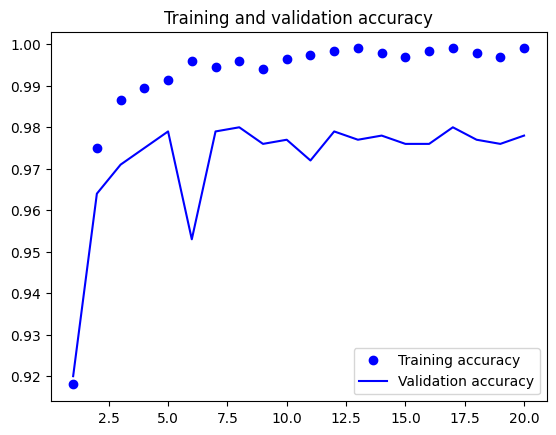

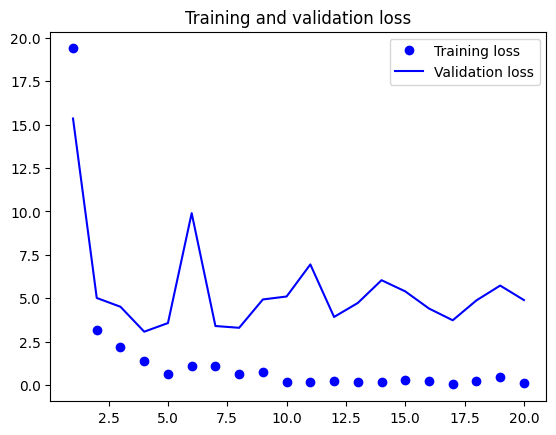

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

You reach a validation accuracy of about 97%—much better than you achieved in the previous section with the small model trained from scratch. This is a bit of an unfair comparison, however, because ImageNet contains many dogs and cats instances, which means that our pretrained model already has very the exact knowledge required for the task at hand. This won’t always be the case when you use pretrained features.

However, the plots also indicate that you’re overfitting almost from the start—despite usin dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.

**Feature extraction together with data augmentation**

Now, let’s review the second technique I mentioned for doing feature extraction, which is much slower and more expensive, but which allows you to use data augmentation during training: creating a model that chains the conv_base with a new dense classifier, and training it end to end on the inputs.

In order to do this, we will **first freeze the convolutional base**. *Freezing* a layer or set of layers means preventing their weights from being updated during training. Here, if you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, you freeze a layer or model by setting its trainable attribute to False:

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Setting trainable to False empties the list of trainable weights of the layer or model:

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
          "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
          "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Now, we can just create a new model that chains together:

1. A data augmentation stage
2. Our frozen convolutional base
3. A dense classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

With this setup, only the weights from the two Dense layers that you added will be trained. That’s a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, you must first compile the model. If you ever modify weight trainability after compilation, you should then recompile the model, or these changes will be ignored.

Let’s train our model. Thanks to data augmentation, it will take much longer for the model to start overfitting, so we can train for more epochs—let’s do 50.

Note: This technique is expensive enough that you should only attempt it if you have access to a GPU — it’s intractable on CPU. If you can’t run your code on GPU, then the previous technique is the way to go.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
#EPOCHS = 50
EPOCHS = 25
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 954ms/step - accuracy: 0.6834 - loss: 97.2066 - val_accuracy: 0.9450 - val_loss: 7.0974
Epoch 2/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8833 - loss: 16.2236 - val_accuracy: 0.8870 - val_loss: 25.0275
Epoch 3/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8730 - loss: 20.2333 - val_accuracy: 0.9390 - val_loss: 7.5636
Epoch 4/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9054 - loss: 11.4579 - val_accuracy: 0.9450 - val_loss: 7.0470
Epoch 5/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9286 - loss: 8.3014 - val_accuracy: 0.9600 - val_loss: 5.7375
Epoch 6/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9220 - loss: 11.6837 - val_accuracy: 0.9470 - val_loss: 7.1918
Epoch 7/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9516 - loss: 4.3345 - val_accuracy: 0.9480 - val_loss: 7.4920
Epoch 8/25
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9476 - loss: 6.0079 - val_accuracy: 

In [ ]:
# Let’s plot the results again. As you can see, you reach a validation accuracy of over 98%. This is a strong improvement over the previous model.

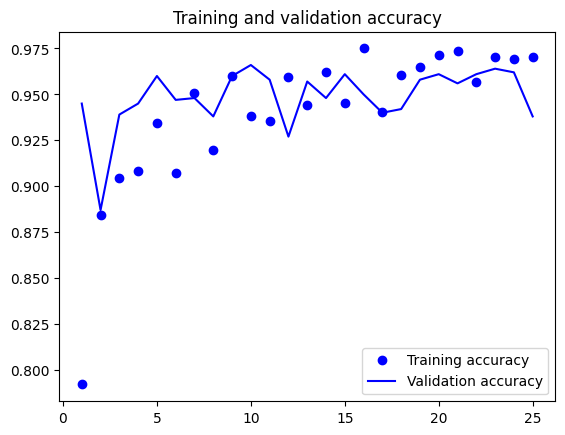

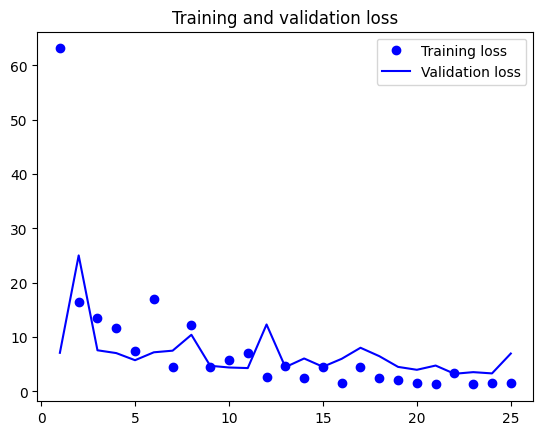

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Let’s check the test accuracy:

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9735 - loss: 2.1749
Test accuracy: 0.970


We get a test accuracy of 97.5%. This is only a modest improvement compared to the previous test accuracy, which is a bit disappointing given the strong results on the validation data. A model’s accuracy always depends on the set of samples you evaluate it on! Some sample sets may be more difficult than others, and strong results on one set won’t necessarily fully translate to all other sets.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_.
Fine-tuning consists in unfreezing a few of the top layers
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`,
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
EPOCHS = 30
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.9676 - loss: 1.7487 - val_accuracy: 0.9640 - val_loss: 2.9130
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9712 - loss: 0.7546 - val_accuracy: 0.9650 - val_loss: 2.5461
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9849 - loss: 0.4347 - val_accuracy: 0.9520 - val_loss: 4.1363
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9764 - loss: 0.8166 - val_accuracy: 0.9550 - val_loss: 2.8815
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9824 - loss: 0.5317 - val_accuracy: 0.9640 - val_loss: 2.5544
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9817 - loss: 0.4449 - val_accuracy: 0.9650 - val_loss: 2.2638
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9800 - loss: 0.5852 - val_accuracy: 0.9620 - val_loss: 2.3482
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9828 - loss: 0.4288 - val_accuracy: 0.967

You can now finally evaluate this model on the test data:

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9721 - loss: 1.6610
Test accuracy: 0.969


Here, you get a test accuracy of 98.5% (again, your own results may be within one percentage point). In the original Kaggle competition around this dataset, this would have been one of the top results. It’s not quite a fair comparison, however, since you used pretrained features that already contained prior knowledge about cats and dogs, which competitors couldn’t use at the time.

On the positive side, by leveraging modern deep-learning techniques, you managed to reach this result using only a small fraction of the training data that was available for the competition (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

Now you have a solid set of tools for dealing with image-classification problems—in particular with small datasets.

### Summary for ConvNets

* Convnets are the best type of machine-learning models for computer-vision tasks. It’s possible to train one from scratch even on a very small dataset, with decent results.
* Convnets work by learning a hierarchy of modular patterns and concepts to represent the visual world.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when you’re working with image data.
* It’s easy to reuse an existing convnet on a new dataset via feature extraction. This is a valuable technique for working with small image datasets.
* As a complement to feature extraction, you can use fine-tuning, which adapts to a new problem some of the representations previously learned by an existing model. This pushes performance a bit further.

**Exercise**

Now apply this to another dataset of your choice and report the performance. This could be a another classification (e.g. CIFAR-10) or task or a regression.

## Training models (gotchas)

Look at the free copy of the book 'machine learning yearning' (Andrew Ng):
<https://d2wvfoqc9gyqzf.cloudfront.net/content/uploads/2018/09/Ng-MLY01-13.pdf>

Read Chapter 4 to 11 to learn about Deep Learning gotchas:

* 4 Scale drives machine learning progress
* 5 Your development and test sets
* 6 Your dev and test sets should come from the same distribution
* 7 How large do the dev/test sets need to be?
* 8 Establish a single-number evaluation metric for your team to optimize
* 9 Optimizing and satisficing metrics
* 10 Having a dev set and metric speeds up iterations
* 11 When to change dev/test sets and metrics